# Deeplens implementation
In this notebook, we perform some basic observations of the dataset generated by the deeplenstronomy wrapper. To run this notebook, an installation of the deeplenstronomy wrapper is necessary.
The residual maps are maps that compare strictly different model. The added noise is moreover really smooth compare to the implementation performed in `datanalysis.ipynb`.
Those differences may come from the image model that is probably defined differently.

## 1. Import

In [1]:
import os, sys
currentdir = os.path.dirname(os.path.realpath('deeplens.ipynb'))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)

import numpy as np
import pandas as pd

import deeplenstronomy.deeplenstronomy as dl
from deeplenstronomy.visualize import view_image

from helpers.data_generation.file_management import read_hdf5
from deeplenshelpers import*


%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
sns.set(style="darkgrid")

import warnings
warnings.filterwarnings("ignore")

## 2. Dataset & Simulated images
We build the dataset with a '.yalm' file where all configurations are defined. The models' parameters vary with a uniform distribution.

Lens' light parameters:
* Model : Sersic ellipse
* Amplitude : $amp = 22$
* Sersic radius : $R_{sersic} = 0.25$
* Sersic index : $n_{sersic}= 2.9$
* Ellipsity* : $e_1 = 0$   and   $e_2 = 0.09$
* Center : $x = 0$ and $y = 0$

Lens' mass variation :
- Model: Power-law Elliptical Mass Distribution

>$\kappa = \frac{3-\gamma }{2}\left ( \frac{\theta_E}{\sqrt{q e_1^2+ e_2^2/q}} \right )^{\gamma-1}$
 
* Einstein radius: $\theta_E \in \mathcal{N}_{log}(\mu:0,\sigma:0.1)$

* Power law slope: $\gamma \in \mathcal{N}_{log}(\mu:0.7,\sigma:0.1)$
* Ellipsity* : $e_1 \in \mathcal{N}(\mu :0, \sigma : 0.2)$   and $e_2 \in \mathcal{N}(\mu :0, \sigma : 0.2)$
* Center : $x = 0$ and $y = 0$

Source variation :
* Model : Sersic ellipse
* Amplitude : $amp \in  \mathcal{U}(20, 24)$
* Sersic radius : $R_{sersic} \in  \mathcal{N}_{log}(\mu:-0.7,\sigma:0.4)$
* Sersic index : $n_{sersic} \in  \mathcal{N}_{log}(\mu:0.7,\sigma:0.4)$
* Ellipsity* : $e_1 \in \mathcal{N}(\mu :0, \sigma : 0.2)$   and $e_2 \in \mathcal{N}(\mu :0, \sigma : 0.2)$
* Center : $x \in \mathcal{U}(-0.5,0.5)$ and $y \in \mathcal{U}(-0.5,0.5)$

Note* : The ellipsity range is determined with the following equations, where $q \in \mathcal{N}(0.7, 1)$ and $\phi \in \mathcal{N}(0, \frac{\pi}{2})$

>$e_1 = \frac{1-q}{1+q}\cos{(2\phi)}$     and     $e_2 = \frac{1-q}{1+q}\sin{(2\phi)} $

In [2]:
config_file_name1 = 'data/configFile/config_model1.yaml' # Mass variation
dataset1 = dl.make_dataset(config_file_name1)

config_file_name2 = 'data/configFile/config_model2.yaml' # Source variation
dataset2 = dl.make_dataset(config_file_name2)

config_file_name3 = 'data/configFile/config_model3.yaml' # Mass & source variation
dataset3 = dl.make_dataset(config_file_name3)

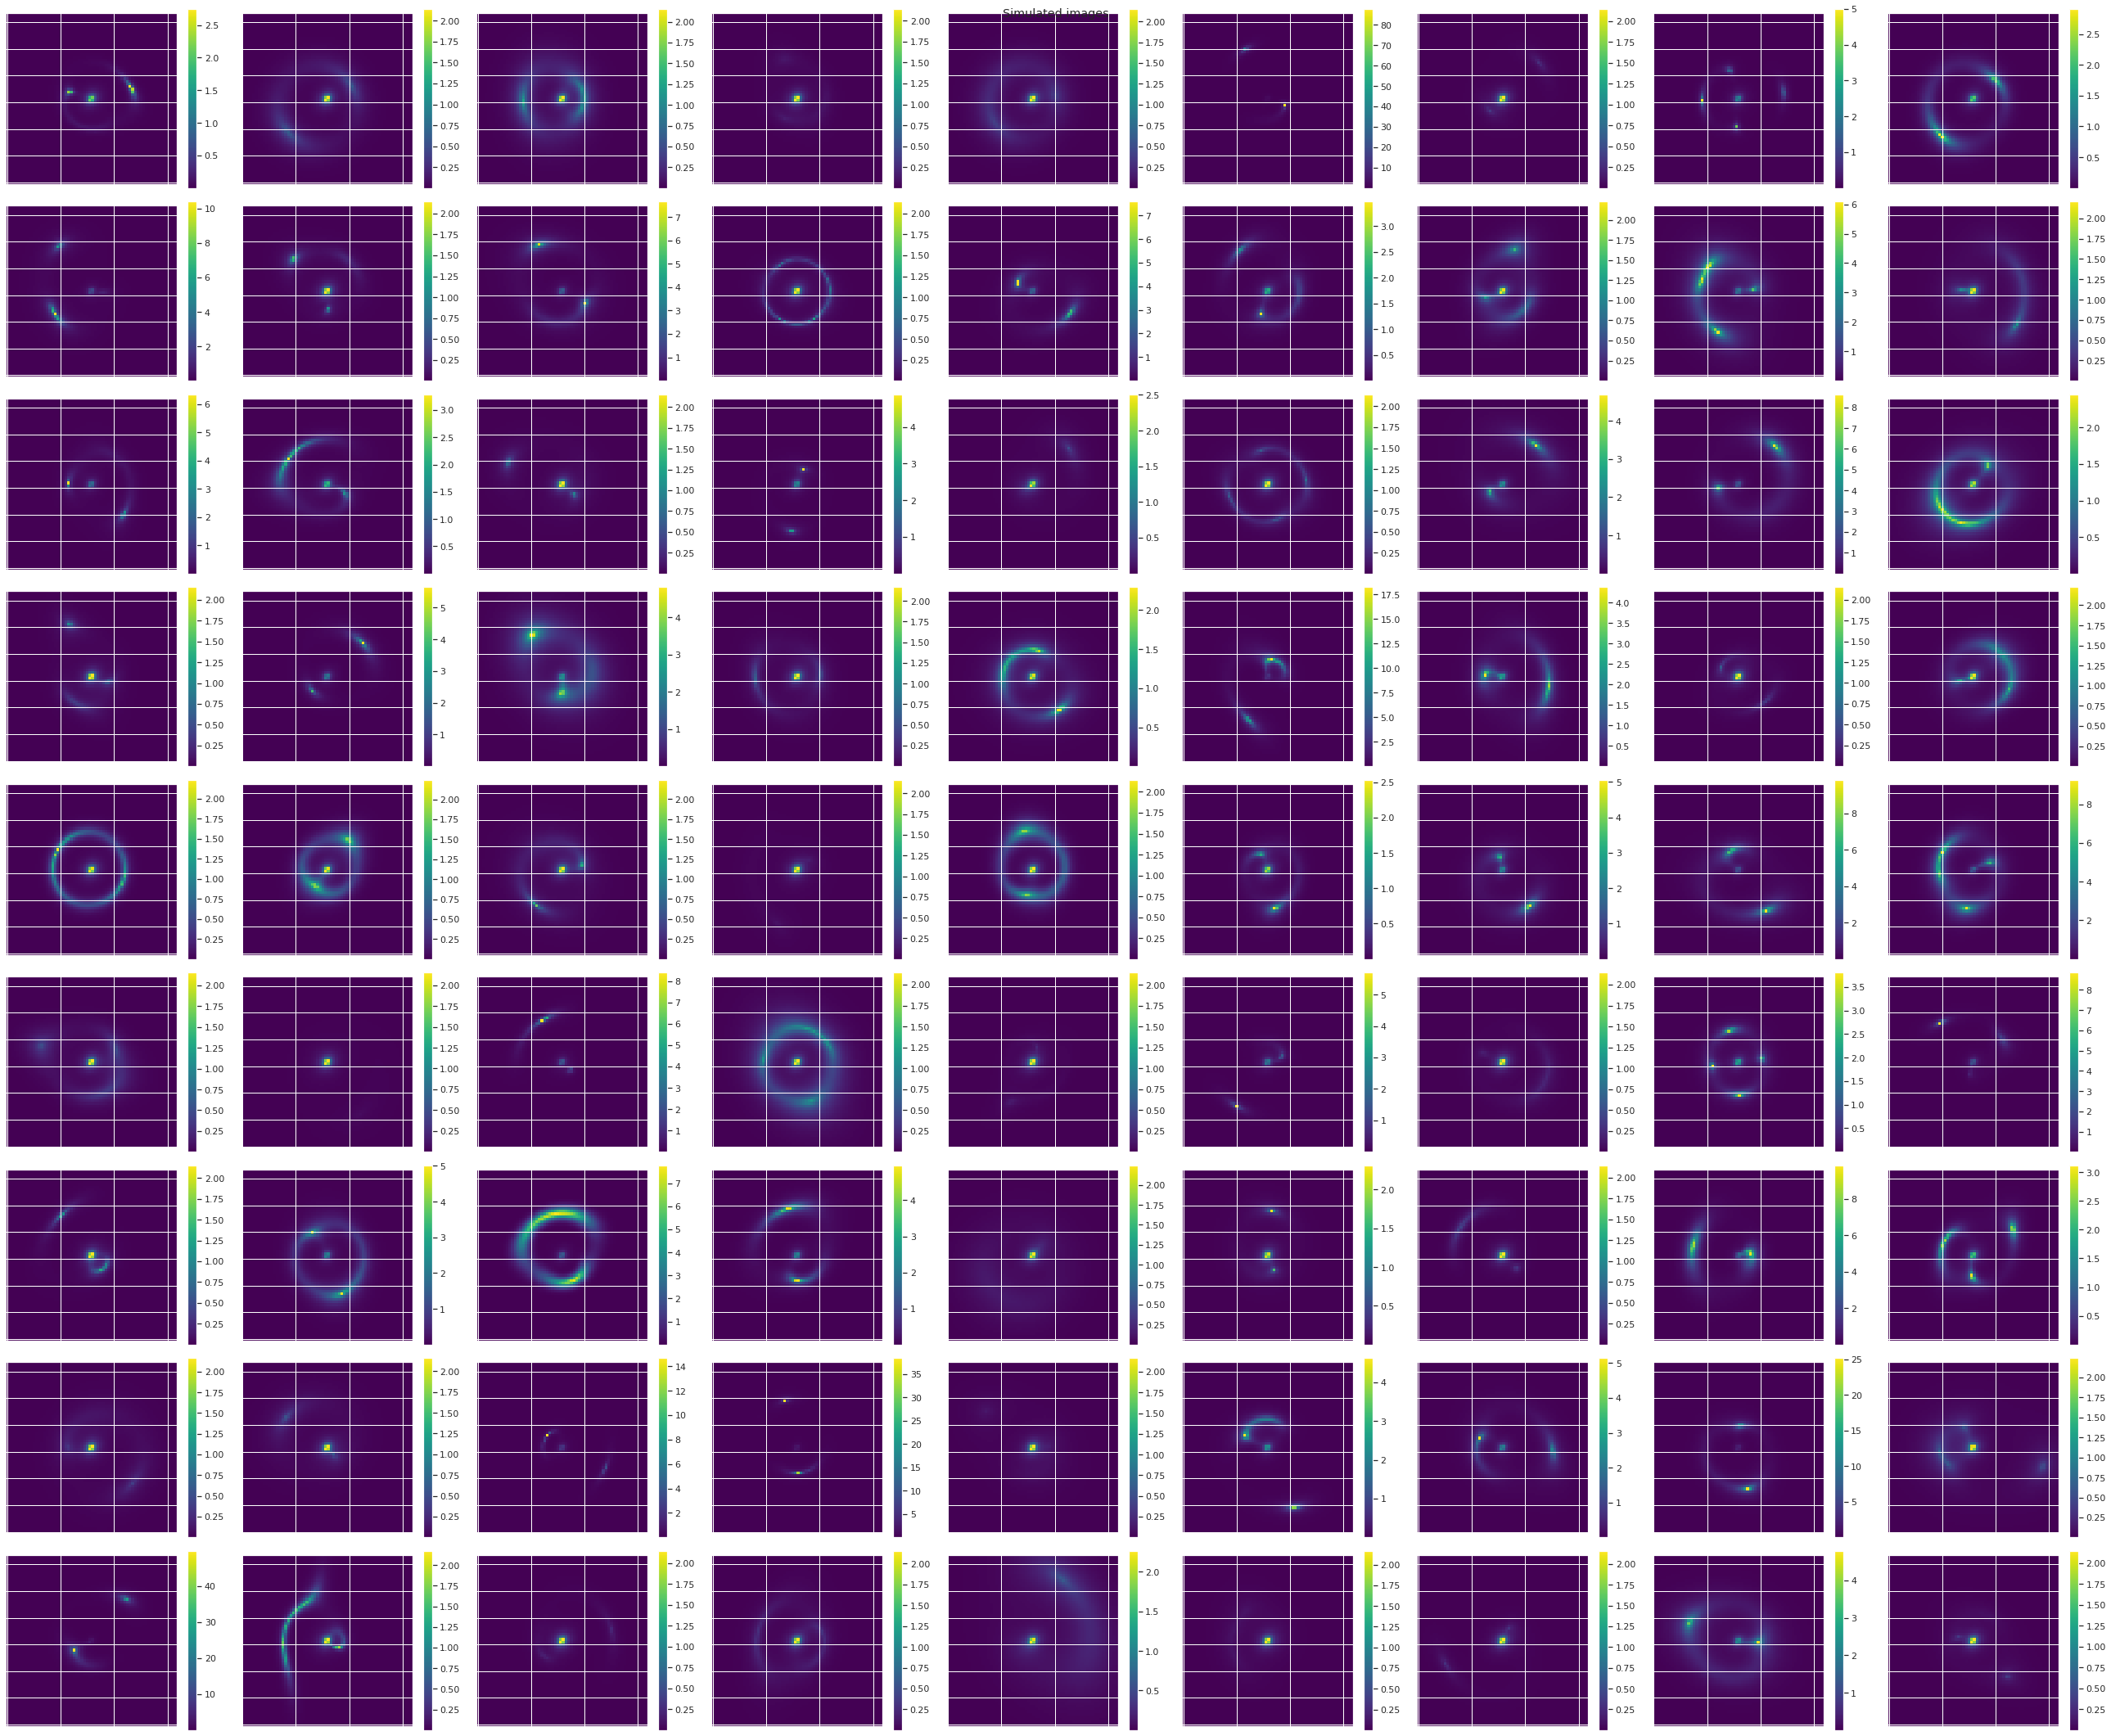

In [3]:
f, axes = plt.subplots(9, 9, figsize=(36, 30), sharex=False, sharey=False)
p_decal = 10

for i in range(0,9):
    for k in range(9):
        
        image_real = dataset3.CONFIGURATION_1_images[i*9+k][0] 
        pos1 = axes[k,i].imshow(image_real, cmap = 'viridis', origin='lower')
        axes[k,i].set_yticklabels([]); axes[k,i].set_xticklabels([])
        f.colorbar(pos1, ax=axes[k,i])

f.suptitle('Simulated images', size = 'large')
f.tight_layout()
plt.show()

plt.show()
f.savefig('../figures/deeplens/deeplens_simulated.png')

## 2. Images generated by the Lenstronomy simulator
### Building the dataset
The dataset is build with `.yalm` files that are defined in the folder `data/configFile/config_model`. The resulting dataset is stored three `.h5` files in folder `data/dataSet/` for each `.yalm` file opened. Generated images are residuals with the model's metadata parameters.

In [4]:
# Build the four classes 
config_repo_model = 'data/configFile/config_model'


for i in np.arange(1,4):
    model_name = config_repo_model + str(i) + '.yaml'
    res = ResidualDeepLens(model_name)
    res.build(i)
print('Data Generation Finished')

Data Generation Finished


In [5]:
metadata = pd.DataFrame()
for i in np.arange(1,4):
    [img, meta] = read_hdf5(str(i), path = "data/dataSet/")
    metadata = pd.concat([metadata,meta], ignore_index=True)
    if i == 1:
        final_array = img
    else:
         final_array = np.concatenate((final_array, img))
metadata ['ID'] = np.arange(0,final_array.shape[0])

print('Reading Data Finished')

Reading Data Finished


## Residual maps

In [6]:
index = metadata.index

indices_noerror = index[[col == [1,0,0] for col in metadata['class']]]
indices_mass = index[[col == [0,1,0] for col in metadata['class']]]
indices_source = index[[col == [0,0,1] for col in metadata['class']]]
indices_masssource = index[[col == [0,1,1] for col in metadata['class']]]

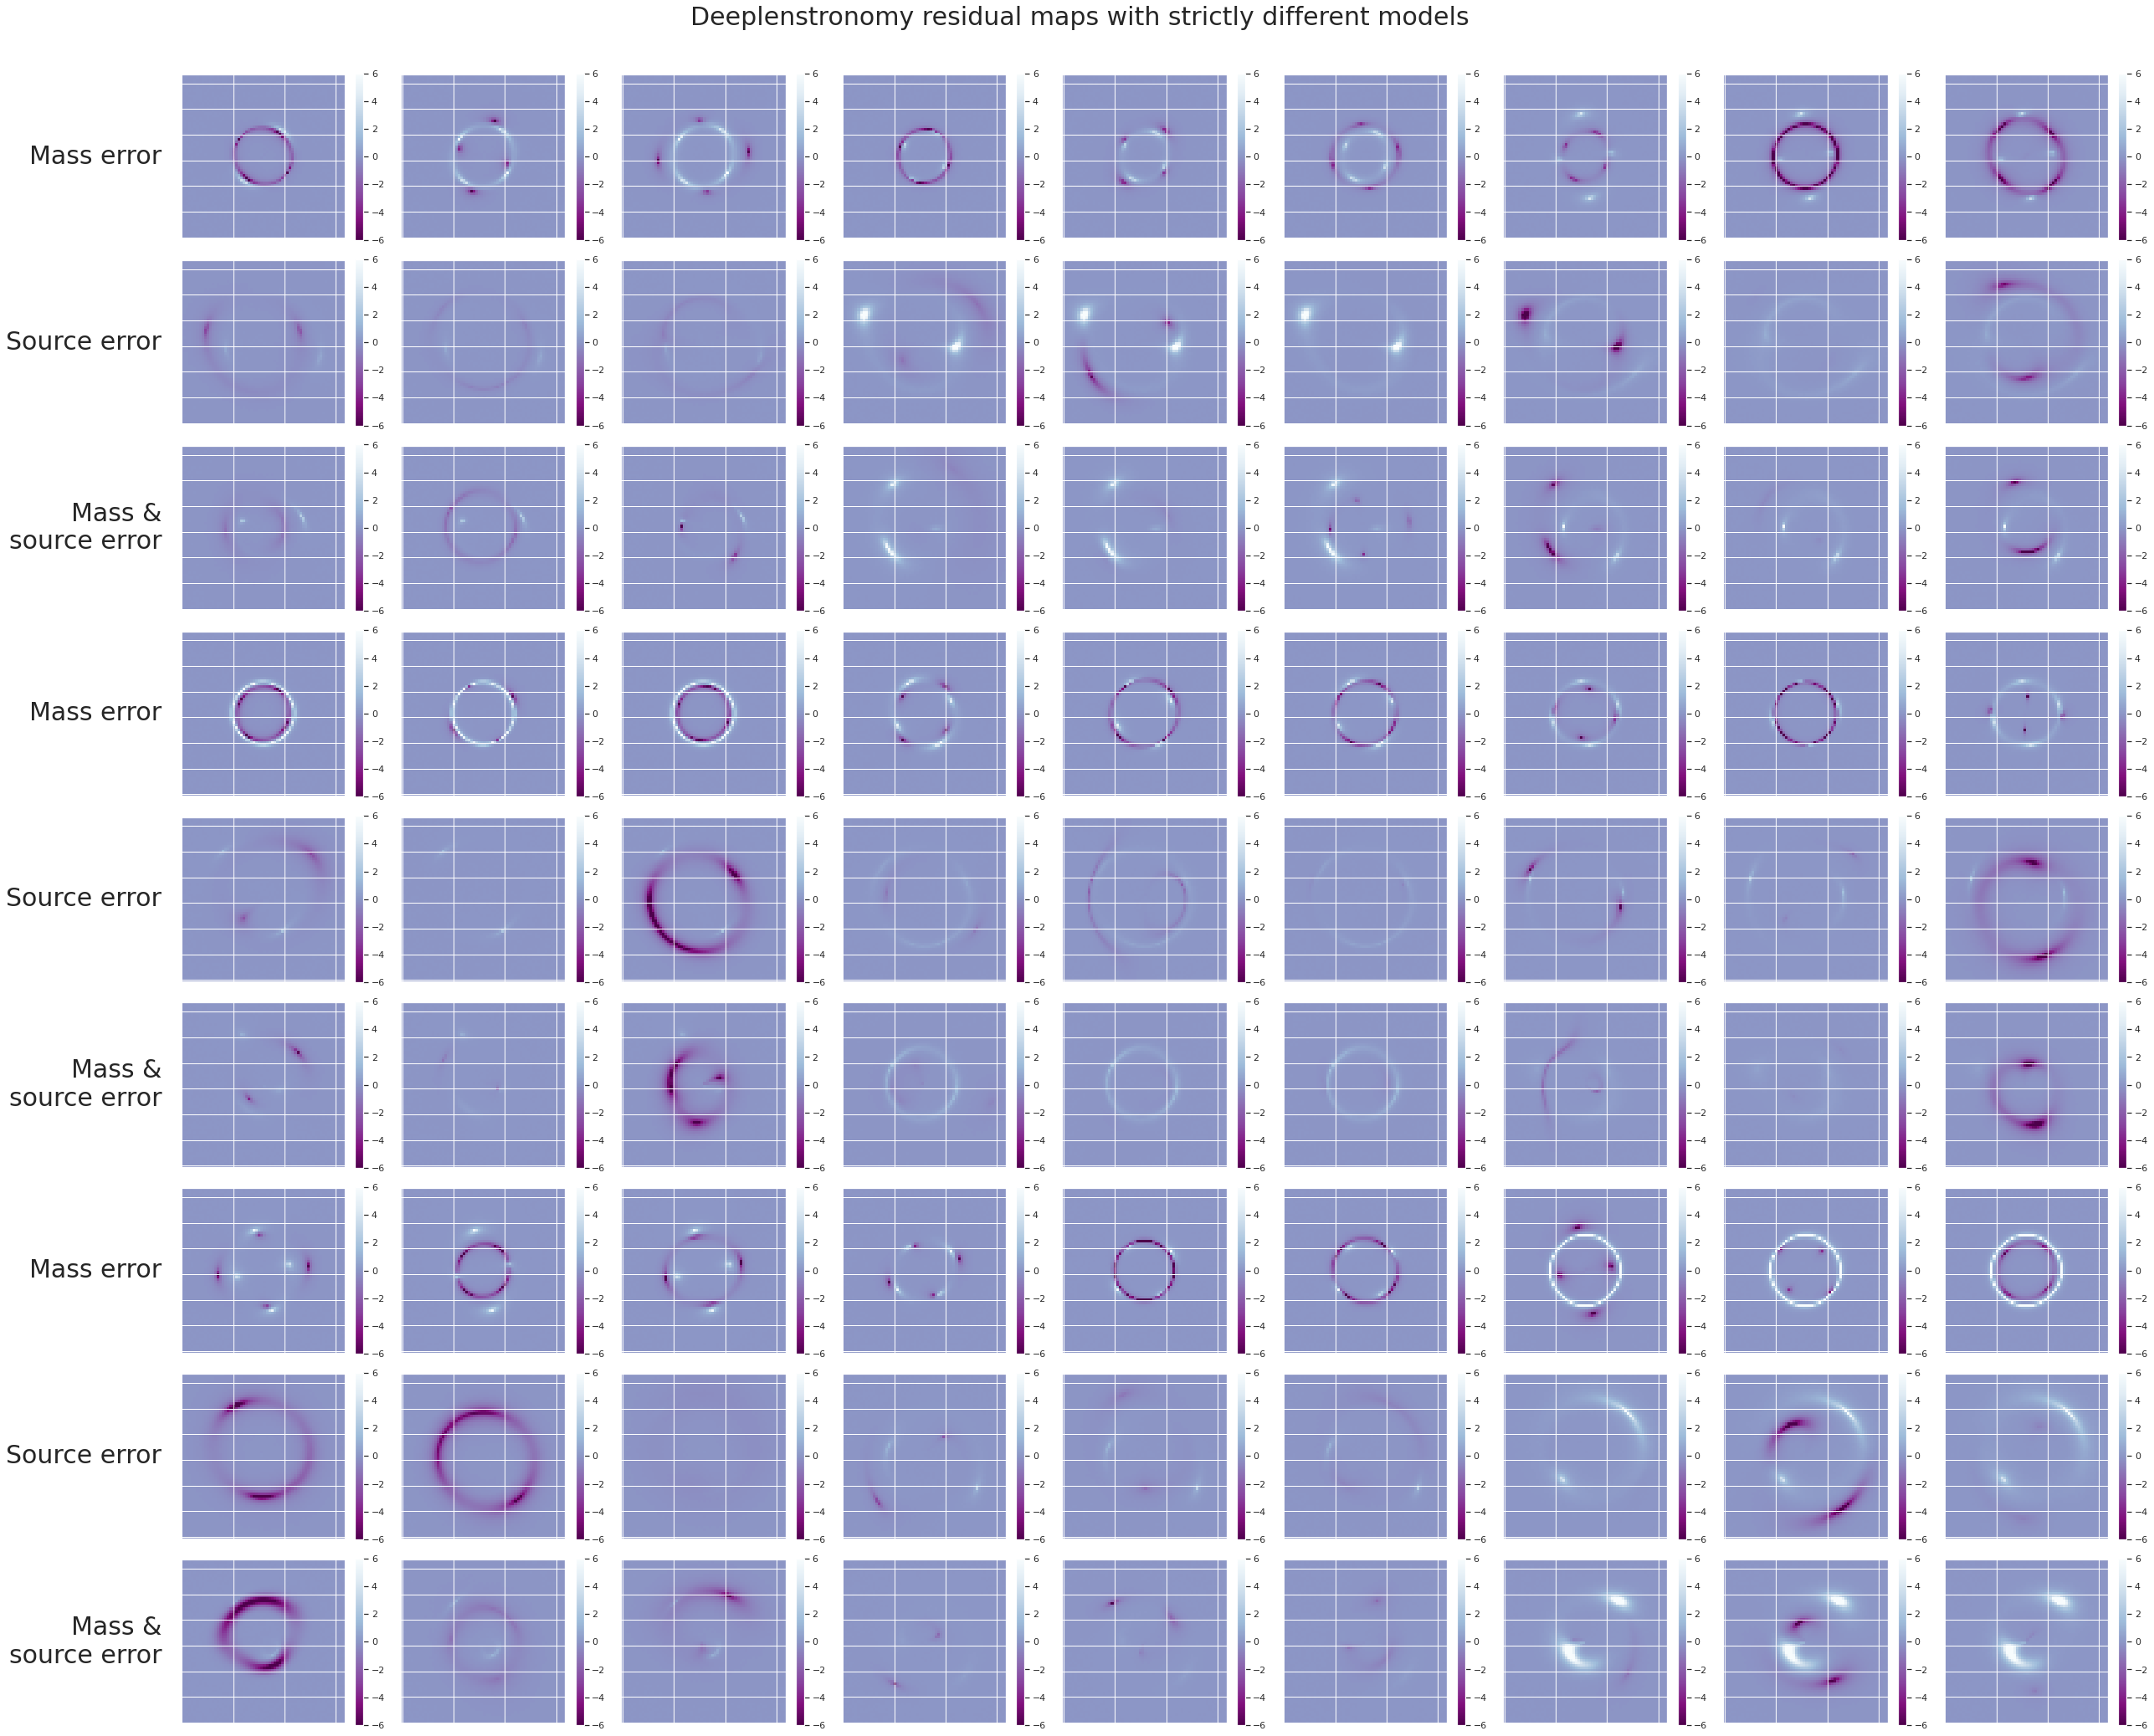

In [7]:
f, axes = plt.subplots(9, 9, figsize=(36, 30), sharex=False, sharey=False)

for count, k in enumerate(np.array([0, 3, 6])):
    for i in range(0,9):
        pos1 = axes[k,i].imshow(final_array[indices_mass[i+9*count],0,:,:], vmin=-6, vmax=6, origin='lower',cmap=plt.cm.BuPu_r)
        pos2 = axes[k+1,i].imshow(final_array[indices_source[i+9*count],0,:,:], vmin=-6, vmax=6, origin='lower',cmap=plt.cm.BuPu_r)
        pos3 = axes[k+2,i].imshow(final_array[indices_masssource[i+9*count],0,:,:], vmin=-6, vmax=6, origin='lower',cmap=plt.cm.BuPu_r)

        axes[k,i].set_yticklabels([]); axes[k,i].set_xticklabels([])
        axes[k+1,i].set_yticklabels([]); axes[k+1,i].set_xticklabels([])
        axes[k+2,i].set_yticklabels([]); axes[k+2,i].set_xticklabels([])
        f.colorbar(pos1, ax=axes[k,i]); f.colorbar(pos2, ax=axes[k+1,i])
        f.colorbar(pos3, ax=axes[k+2,i])
    
    
    pad = 5
    font = 30

    axes[k,0].annotate('Mass error', xy=(0, 0.5), xytext=(-axes[k,0].yaxis.labelpad - pad, 0),
                       xycoords=axes[k,0].yaxis.label, textcoords='offset points', ha='right', va='center',fontsize=font)
    axes[k+1,0].annotate('Source error', xy=(0, 0.5), xytext=(-axes[k+1,0].yaxis.labelpad - pad, 0),
                       xycoords=axes[k+1,0].yaxis.label, textcoords='offset points', ha='right', va='center',fontsize=font)
    axes[k+2,0].annotate('Mass &\nsource error', xy=(0, 0.5), xytext=(-axes[k+2,0].yaxis.labelpad - pad, 0),
                       xycoords=axes[k+2,0].yaxis.label, textcoords='offset points', ha='right', va='center',fontsize=font)
    
f.suptitle('Deeplenstronomy residual maps with strictly different models', size = 'large',fontsize=font)
plt.tight_layout(rect=[0, 0.02, 1, 0.97])
plt.show()

plt.show()
f.savefig('../figures/deeplens/deeplens_residuals.png')